# Demo 3 - Automate Model Selection with AML Service

Get the images to use in your experiment

In [1]:
import os
import urllib.request
os.makedirs('./data', exist_ok = True)
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')
print('Execution Complete')

Execution Complete


The data load code uses the helper functions below so run that code to define them

In [2]:
import gzip
import numpy as np
import struct
# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols),dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
        return res
# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

Now you will load the images to local storage. Some images are displayed to confirm the code ran
correctly. This may take a couple of minutes to run

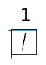

In [4]:
# To help the model to converge faster , you shrink the intensity values (X) from 0-255 to 0-1
X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)
X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)
# Display some images...
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
plt.subplot(1, sample_size, count)
plt.axhline('')
plt.axvline('')
plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

Azure Machine Learning service Workspace in the Azure portal

In [5]:
# import package and use get function to access Workspace
# Be sure to replace the subscription id with your subscription id
from azureml.core import Workspace,Experiment ,Run
ws = Workspace.get(name='BAUERWK',
subscription_id='52b56929-ee84-495c-91c3-a84dfacbc9d2',
resource_group='DP100'
)

In [6]:
ws.get_details()

{'id': '/subscriptions/52b56929-ee84-495c-91c3-a84dfacbc9d2/resourceGroups/DP100/providers/Microsoft.MachineLearningServices/workspaces/BAUERWK',
 'name': 'BAUERWK',
 'location': 'eastus',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Enterprise',
 'workspaceid': 'e45c443e-6661-4015-b3c2-7f2f6b9ddf4d',
 'description': '',
 'friendlyName': '',
 'creationTime': '2020-01-16T17:39:56.7000258+00:00',
 'containerRegistry': '/subscriptions/52b56929-ee84-495c-91c3-a84dfacbc9d2/resourceGroups/DP100/providers/Microsoft.ContainerRegistry/registries/bauerwkd9e82596',
 'keyVault': '/subscriptions/52b56929-ee84-495c-91c3-a84dfacbc9d2/resourcegroups/dp100/providers/microsoft.keyvault/vaults/bauerwk2103398596',
 'applicationInsights': '/subscriptions/52b56929-ee84-495c-91c3-a84dfacbc9d2/resourcegroups/dp100/providers/microsoft.insights/components/bauerwk8495726486',
 'identityPrincipalId': '5e4de374-64a3-4a0d-b555-05478feb76aa',
 'identityTenantId': '60623c36-25e7-4dec

Now, you create an experiment within this workspace using the following code

In [7]:
from azureml.core import Workspace,Experiment ,Run
#Create an experiment
experiment = Experiment(workspace = ws, name = "my-third-experiment")

### Define the machine learning objective and constraints

The first step is to define the machine learning objective, using AutoMLConfig, as shown below

In [8]:
from azureml.train.automl import AutoMLConfig
import logging
automl_config = AutoMLConfig(task = 'regression',
iteration_timeout_minutes = 30,
iterations = 3,
primary_metric = 'spearman_correlation',
n_cross_validations = 5,
debug_log = 'automl.log',
verbosity = logging.INFO,
X = X_train,
y = y_train)
print('Execution Complete')

WARNING - The AutoMLConfig inputs you have specified will soon be deprecated. Please use the AutoMLConfig shown in our documentation: https://aka.ms/AutoMLConfig


Execution Complete


### Launch the AutoML Process

In [11]:
# It Might takes several minutes to complete
local_run = experiment.submit(automl_config, show_output = True)
print('Execution Complete')

Running on local conda or docker.


SnapshotException: SnapshotException:
	Message: ====================================================================

While attempting to take snapshot of /home/nbuser/library/Demos
Your total snapshot size exceeds the limit of 300.0 MB.
Please see http://aka.ms/aml-largefiles on how to work with large files.

====================================================================


	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "====================================================================\n\nWhile attempting to take snapshot of /home/nbuser/library/Demos\nYour total snapshot size exceeds the limit of 300.0 MB.\nPlease see http://aka.ms/aml-largefiles on how to work with large files.\n\n====================================================================\n\n"
    }
}

### Retrieve the Best Model

In [ ]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

The best model can also be retrieved by running the following code

In [ ]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

In [ ]:
print(best_run)